# Generative Deep Learning - **Deep Dream**

## Introduction

For this submission I will be exploriing the use of the **DeepDream** technique, similar to what we have encountered in the reading of chapter 12 in *Deep Learning with Python*[1].

### What is DeepDream?
DeepDream is an artistic image-modifiation technique[2] that uses a convolutional neural network to draw it's representation. First released by Google in the summer of 2015[2]. It is notorious for it's style - enveloping it's input image within a 'dream-like' psychedelia; full of pareidolic artificates: bird feathers, dog eyes, and other such things – a byproduct of of the fact it was trained on the ImageNet dataset[3], which has a overarching presence of dog breed and bird images.

#### How does it work?
Starting from a noisy input, the model will begin to latch onto to patterns learned within the noise, distorting the image overtime. Input images are processed at different *octaves* (scales), smaller octave images are 'dreamt' upscaled, and immediately reinjected with the features learnt from the the following octave, to preserve detail and minimise unwanted noise. And lastly on a layer to layer occurence; activations of functions are maximised, so that visual patterns are enhanced, as features are mixed in together and amplified unto the output.

### Workflow

Seeing as we are working with a generative network, one comissioned for artistry, it makes sense to incoperate artistic awareness into the development in the model, my process should be informed by the artistic quality of the output. Various points of interest that will affect the output of the model are:
- Activate differnt layers of the network. This will allow for different patterns to be drawn out of the input image: more abstract representations within lower layers, and more 'humanly recognisable' ones further up our model architecture.
- This model will initially work with importing the *Inception V3 model* (as this is the model in which the official DeepDream implementation was based on), we can also make use of other pretrained Convnets, such as: VGG16, VGG19, Xception, ResNet50.
- The implementation of loss within our model has a significant effect on the output image; we can pick a "scalar score that weights the contribution of the layer to loss we will seek to maximise during gradient ascent"[1].

## Implementation

### Inspecting our prerequisites

I will be training on one of my favourite artworks, Francis Bacon's *Two Figures At A Window, 1953* [4] - it is a sparsely populated image, featuring only a singular focal point, allowing alot of room for the DeepDream's hallucinatory effects to take place.

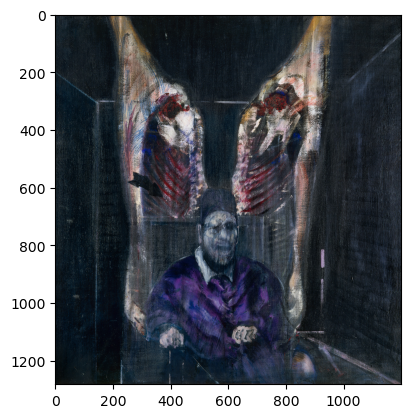

In [ ]:
#for local use
myfile = 'bacon2.jpg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(myfile)
imgplot = plt.imshow(img)

import all necessary modules

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3, vgg16, vgg19, resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import numpy as np
import scipy
import scipy.misc
import imageio
import h5py


When making use of pretrained models, it is important to import the backend of keras in order to disable the updating of weights, as we wish only to use the model for image generation. Original experimentations within the notebook were done using the inception_v3 model[5], as this was the model used in the original DeepDream implementation[1].

In [ ]:
K.set_learning_phase(False)
model = inception_v3.InceptionV3(weights='imagenet', include_top=False) #note this last arguement does not include the convolutional base.

/opt/homebrew/Caskroom/miniconda/base/envs/tfenv/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


As explored earlier, to explore the artistic capabilities of the DeepDream algorithm, affecting the output image is done by manipulating the processing of the input to various layers within the model architecture. To do this it is necessary to know the names of the layers within the model, and accquaint oneself with the model architecture. Below the model's architecture has already been studied, therefore the pretrained_models dict has access to all the relevant namespaces and valid layer names to allow better modularity further into this notebook.

## model implementation and first use

### Setup

In [ ]:
#dict of pretrained models to experiment with
pretrained_models = {
    'inception_v3': {"model":inception_v3.InceptionV3(weights='imagenet', include_top=False),
        "namespace" : inception_v3, "layer_contributions" : {
            'mixed1': 1.,
            'mixed2': 3.5,
            'mixed3': 0.5,
            'mixed7': 2.5,
            'mixed8': 4.5,
            'mixed9': 6.5,
            'mixed10': 8.5,}},
    'vgg16': {"model":vgg16.VGG16(weights='imagenet', include_top=False), "namespace" : vgg16,
        "layer_contributions" : {
            'block1_pool': 4.,
            'block2_pool': 1.5,
            'block3_pool': 2.,
            'block4_pool': 1.5,
            'block5_pool': 4.5,}},
    'vgg19': {"model":vgg19.VGG19(weights='imagenet', include_top=False), "namespace" : vgg19,
        "layer_contributions" : {
            'block1_pool': 1.5,
            'block2_pool': 2.5,
            'block3_pool': 3.5,
            'block4_pool': 0.5,
            'block5_pool': 1.5,}},
    'resnet50': {"model":resnet50.ResNet50(weights='imagenet', include_top=False), "namespace" : resnet50,
        "layer_contributions" : {
            'conv3_block4_out': 0.5,
            'conv4_block1_out': 1.5,
            'conv5_block3_out': 2.5}},
}

#call the model of choice
model = pretrained_models['vgg19']['model']
#model.summary()

Global variables are defined here to allow for modularity around this notebook; we are specifically looking at the hyperparameters of our model here, this allows us to fine tune the artistic intention of our model. A function is created in order to load the custom loss weights into a dict for use in the model.

In [ ]:
#parameters. to be changed on each iteration.
#dict of layers to experiment with (different names required for each pretrained model).

step = 0.02
num_octave = 10
octave_scale = 1.2
iterations = 30
max_loss = 100.

def instantiateweightdict():
    output_dict = dict(
        [
            (layer.name, layer.output)
            for layer in [model.get_layer(name)
                for name in pretrained_models[f'{model.name}']['layer_contributions'].keys()]
        ]
    )
    return output_dict
feature_extractor = keras.Model(inputs=model.inputs, outputs=instantiateweightdict())

### building the model

#### loss, gradient ascent, and utilities

During the gradient ascent process, we wish to maximise a weighted mean of the activations within the layers specified within our 'layer_contributions' key inside the 'pretrained_models' dict.

In [ ]:
#custom loss function
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = pretrained_models[f'{model.name}']['layer_contributions'][name]
        activation = features[name]
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), 'float32'))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss


The gradient ascent feature is split between two functions: one allows us to iterate over the image a set amount of times per octave, the other allows us to perform the arithmetic of the gradient ascent process.

In [ ]:
#gradient ascent function
@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    image += learning_rate * grads
    return loss, image

def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            tf.print(f"... !!Loss value exceeds max_loss. Loss: {loss}")
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

Preprocessing the image entails us initialising a numpy array storing the rgb values of the image. We then call the member of our pretrained model 'preprocess_input' function, which will normalise the image to the range of the model's training data, and fit it within a tensor.

In [ ]:
#image processing utility functions
import numpy as np
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = pretrained_models[f'{model.name}']['namespace'].preprocess_input(img)
    return img
def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

To allow for better modularity within the code. A function is created to allow for the calling of: the loss functions, processing utility functions and gradient ascent functions. This function also allows for the saving of the output image.

In [ ]:
def generate():
    original_img = preprocess_image(myfile)
    original_shape = original_img.shape[1:3]
    successive_shapes = [original_shape]
    for i in range(1, num_octave):
        shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
        successive_shapes.append(shape)
    successive_shapes = successive_shapes[::-1]
    shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

    img = tf.identity(original_img)
    for i, shape in enumerate(successive_shapes):
        print(f"Processing octave {i} with shape {shape}")
        img = tf.image.resize(img, shape)
        img = gradient_ascent_loop(
            img, iterations=iterations, learning_rate=step, max_loss=max_loss
        )
        upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
        same_size_original = tf.image.resize(original_img, shape)
        lost_detail = same_size_original - upscaled_shrunk_original_img
        img += lost_detail
        shrunk_original_img = tf.image.resize(original_img, shape)

    keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

### Generating the dream image

In [ ]:
generate()
dreamimg = mpimg.imread('dream.png')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img, aspect='auto')
ax2.imshow(dreamimg, aspect='auto')
plt.show()

Processing octave 0 with shape (248, 232)


2023-01-08 18:17:23.585115: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


... !!Loss value exceeds max_loss. Loss: 3712445.0
Processing octave 1 with shape (298, 279)


KeyboardInterrupt: 

## experimentation environment

Processing octave 0 with shape (583, 546)
... Loss value at step 0: 7.78
... Loss value at step 1: 7.83
... Loss value at step 2: 7.87
... Loss value at step 3: 7.92
... Loss value at step 4: 7.97
Processing octave 1 with shape (758, 710)
... Loss value at step 0: 7.00
... Loss value at step 1: 7.05
... Loss value at step 2: 7.10
... Loss value at step 3: 7.16
... Loss value at step 4: 7.21
Processing octave 2 with shape (986, 923)
... Loss value at step 0: 6.61
... Loss value at step 1: 6.66
... Loss value at step 2: 6.71
... Loss value at step 3: 6.76
... Loss value at step 4: 6.80
Processing octave 3 with shape (1282, 1200)
... Loss value at step 0: 5.79
... Loss value at step 1: 5.83
... Loss value at step 2: 5.88
... Loss value at step 3: 5.92
... Loss value at step 4: 5.96


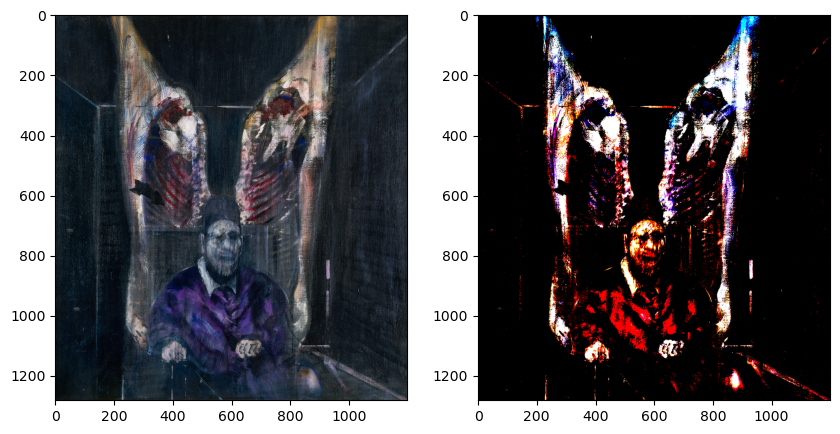

In [ ]:
model = pretrained_models['resnet50']['model']
feature_extractor = keras.Model(inputs=model.inputs, outputs=instantiateweightdict())

num_octave = 4
octave_scale = 1.3
iterations = 5
max_loss = 3000.
step = 0.001

generate()
dreamimg = mpimg.imread('dream.png')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img, aspect='auto')
ax2.imshow(dreamimg, aspect='auto')
plt.show()

## results

### inception_v3 example 1:

model = 'inception_v3'

num_octave = 5

octave_scale = 1.3

iterations = 10

max_loss = 50.

step = 0.03

![image.png](attachment:image.png)

### inception_v3 example 2:

num_octave = 5

octave_scale = 1.1

iterations = 10

max_loss = 30.

step = 0.1

![image.png](attachment:image.png)